<font size=5>신용카드 연체 예측 AI</font>

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')


# Data Load

In [235]:
train = pd.read_csv("./dataset/train.csv")

In [236]:
print(train.shape)
print(train.info())
train.head()

(26457, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   DAYS_BIRTH     26457 non-null  int64  
 3   car            26457 non-null  object 
 4   reality        26457 non-null  object 
 5   occyp_type     18286 non-null  object 
 6   family_size    26457 non-null  int64  
 7   child_num      26457 non-null  int64  
 8   income_total   26457 non-null  float64
 9   income_type    26457 non-null  object 
 10  edu_type       26457 non-null  object 
 11  family_type    26457 non-null  object 
 12  house_type     26457 non-null  object 
 13  DAYS_EMPLOYED  26457 non-null  int64  
 14  FLAG_MOBIL     26457 non-null  int64  
 15  work_phone     26457 non-null  int64  
 16  phone          26457 non-null  int64  
 17  email          26457 non-null  int64  

,index,gender,DAYS_BIRTH,car,reality,occyp_type,family_size,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
0,0,F,-13899,N,N,NaN,2,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-4709,1,0,0,0,-6,1
1,1,F,-11380,N,Y,Laborers,3,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-1540,1,0,0,1,-5,1
2,2,M,-19087,Y,Y,Managers,2,0,450000.0,Working,Higher education,Married,House / apartment,-4434,1,0,1,0,-22,2
3,3,F,-15088,N,Y,Sales staff,2,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-2092,1,0,1,0,-37,0
4,4,F,-15037,Y,Y,Managers,2,0,157500.0,State servant,Higher education,Married,House / apartment,-2105,1,0,0,0,-26,2


## Survived : Traget Feature

<AxesSubplot:>

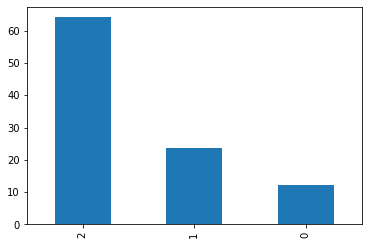

In [237]:
train["credit"].value_counts() 
(train["credit"].value_counts() / train.shape[0]) * 100
((train["credit"].value_counts() / train.shape[0]) * 100).plot(kind='bar')

In [238]:
def my_dfcheck(prm='null'):  #파라미터 : 'null' 또는 'unique'
    if prm == 'unique':
        s = train.nunique()
    else:
        s = train.isna().sum()
    rate = np.round( (s.values  / len(train)) *100,  1)
    dic = {"컬럼":s.index , "카운트":s.values, "비율":rate}
    df = pd.DataFrame(dic).sort_values('카운트', ascending=False)
    return df.T

In [239]:
my_dfcheck ('null') 

,5,0,11,18,17,16,15,14,13,12,10,1,9,8,7,6,4,3,2,19
컬럼,occyp_type,index,family_type,begin_month,email,phone,work_phone,FLAG_MOBIL,DAYS_EMPLOYED,house_type,edu_type,gender,income_type,income_total,child_num,family_size,reality,car,DAYS_BIRTH,credit
카운트,8171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
비율,30.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

## 결측
* 16  occyp_type     18286 non-null  object 

In [240]:
my_dfcheck('unique')

,0,2,13,8,18,5,6,7,12,11,10,9,19,1,4,15,16,17,3,14
컬럼,index,DAYS_BIRTH,DAYS_EMPLOYED,income_total,begin_month,occyp_type,family_size,child_num,house_type,family_type,edu_type,income_type,credit,gender,reality,work_phone,phone,email,car,FLAG_MOBIL
카운트,26457,6621,3470,249,61,18,10,9,6,5,5,5,3,2,2,2,2,2,2,1
비율,100.0,25.0,13.1,0.9,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 유일값
* 0   index          26457 non-null  int64 

In [241]:
train.drop(["index"], axis=1, inplace=True)

## Object 타입
* binary : ['gender', 'car', 'reality'] 
* multi  : ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

In [242]:
obj_col_list = train.select_dtypes(include='object').columns.tolist()
print(obj_col_list)
train[obj_col_list].head()

['gender', 'car', 'reality', 'occyp_type', 'income_type', 'edu_type', 'family_type', 'house_type']


,gender,car,reality,occyp_type,income_type,edu_type,family_type,house_type
0,F,N,N,NaN,Commercial associate,Higher education,Married,Municipal apartment
1,F,N,Y,Laborers,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment
2,M,Y,Y,Managers,Working,Higher education,Married,House / apartment
3,F,N,Y,Sales staff,Commercial associate,Secondary / secondary special,Married,House / apartment
4,F,Y,Y,Managers,State servant,Higher education,Married,House / apartment


## Numeric 타입
* unique : ['index'] 
* target : ['credit'] 
* 범주형  : ['FLAG_MOBIL', 'work_phone', 'phone', 'email']
* 연속형  : ['income_total'] ['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month'] ['child_num','family_size']

In [243]:
obj_col_list = train.select_dtypes(exclude='object').columns.tolist()
print(obj_col_list)
train[obj_col_list].head()

['DAYS_BIRTH', 'family_size', 'child_num', 'income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'begin_month', 'credit']


,DAYS_BIRTH,family_size,child_num,income_total,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
0,-13899,2,0,202500.0,-4709,1,0,0,0,-6,1
1,-11380,3,1,247500.0,-1540,1,0,0,1,-5,1
2,-19087,2,0,450000.0,-4434,1,0,1,0,-22,2
3,-15088,2,0,202500.0,-2092,1,0,1,0,-37,0
4,-15037,2,0,157500.0,-2105,1,0,0,0,-26,2


## 아웃라이어 (Outlier) : 이상치
* child_num   :  14(3), 19(1)
* family_size :  15(3), 20(1)

<pre>
train = train.drop( ['c1', 'c2'] , axis=1)
train = train.drop( [idx1, idx2] , axis=0)

In [244]:
train[obj_col_list].describe()

,DAYS_BIRTH,family_size,child_num,income_total,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
count,26457.000000,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,-15958.053899,2.196848,0.428658,1.873065e+05,59068.750728,1.0,0.224742,0.294251,0.091280,-26.123294,1.519560
std,4201.589022,0.916717,0.747326,1.018784e+05,137475.427503,0.0,0.417420,0.455714,0.288013,16.559550,0.702283
min,-25152.000000,1.000000,0.000000,2.700000e+04,-15713.000000,1.0,0.000000,0.000000,0.000000,-60.000000,0.000000
25%,-19431.000000,2.000000,0.000000,1.215000e+05,-3153.000000,1.0,0.000000,0.000000,0.000000,-39.000000,1.000000
50%,-15547.000000,2.000000,0.000000,1.575000e+05,-1539.000000,1.0,0.000000,0.000000,0.000000,-24.000000,2.000000
75%,-12446.000000,3.000000,1.000000,2.250000e+05,-407.000000,1.0,0.000000,1.000000,0.000000,-12.000000,2.000000
max,-7705.000000,20.000000,19.000000,1.575000e+06,365243.000000,1.0,1.000000,1.000000,1.000000,0.000000,2.000000


In [245]:
train[train['child_num']>=14][['child_num','family_size']]

,child_num,family_size
8462,14,15
9021,14,15
10731,19,20
25390,14,15


In [246]:
drop_idx = train[train['child_num']>=14][['child_num','family_size']].index
drop_idx

Int64Index([8462, 9021, 10731, 25390], dtype='int64')

In [247]:
train.shape

(26457, 19)

In [248]:
# train = train.drop( [8462, 9021, 10731, 25390] , axis=0)
train = train.drop( drop_idx , axis=0)

In [249]:
train.shape

(26453, 19)

# Feature Engineering

## occyp_type(직업유형) 결측처리 
* occyp_type이 NaN이다  == 일하는중_YN(0) == DAYS_EMPLOYED가 양수다

In [250]:
train['occyp_type'].isna().sum()

8171

* 신규 컬럼 : 일하는중_YN
DAYS_EMPLOYED 양수이면 휴직중이다.

<pre>
현재 재직중이다 == 일하는중_YN = Y(1)
현재 집에있다   == 일하는중_YN = N(0)

In [251]:
train['일하는중_YN'] = train['DAYS_EMPLOYED'].apply(lambda x : 0 if x > 0 else 1)

In [252]:
train['일하는중_YN'].value_counts()

1    22015
0     4438
Name: 일하는중_YN, dtype: int64

In [253]:
pd.crosstab(train['occyp_type'], train['일하는중_YN'] )

일하는중_YN,1
occyp_type,
Accountants,902
Cleaning staff,403
Cooking staff,457
Core staff,2646
Drivers,1572
HR staff,62
High skill tech staff,1040
IT staff,41
Laborers,4512


* 일을하고 있는데도 occyp_type이 널인경우 == 최빈도

In [254]:
idx = train[(train['일하는중_YN']==1) & (train['occyp_type'].isna()==True) ]['occyp_type'].index
idx

Int64Index([    0,     8,    19,    20,    23,    27,    49,    54,    72,
               76,
            ...
            26419, 26420, 26424, 26426, 26430, 26433, 26435, 26437, 26449,
            26453],
           dtype='int64', length=3733)

In [255]:
train.loc[idx, 'occyp_type'] = 'Laborers'

* 정말로 일을 안하고 있어서  occyp_type이 널인경우 == 백수('')

In [256]:
train[train['일하는중_YN']==0]['occyp_type']

14       NaN
18       NaN
21       NaN
24       NaN
46       NaN
        ... 
26431    NaN
26432    NaN
26439    NaN
26441    NaN
26443    NaN
Name: occyp_type, Length: 4438, dtype: object

In [257]:
train['occyp_type'].fillna('', inplace=True)

In [258]:
train['occyp_type'].isna().sum()

0

## 카테고리화 == 인코딩 (글자 --> 숫자)
<pre>
object   binary  : ['gender', 'car', 'reality']
object   multi   : ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

* get_dummies() 대상 선정 : 점수 봐가면서 결정

In [259]:
multi_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
for col in multi_cols:
    print(col, train[col].nunique())

income_type 5
edu_type 5
family_type 5
house_type 6
occyp_type 19


In [260]:
train[col].unique()  #pd.unique(train[col])

array(['Laborers', 'Managers', 'Sales staff', 'High skill tech staff',
       'Core staff', 'Drivers', 'Medicine staff', 'Accountants', '',
       'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [261]:
train[col].nunique()

19

* 글자 --> 숫자
<pre>
dict = {"F":1, "M":0}
train["gender"] = train["gender"].map(dict)

In [262]:
col_list = ['gender', 'car', 'reality'] + ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
print(col_list)

for col in col_list:
    arr = train[col].unique()
    dict = {}
    for i, key in enumerate(arr):  #['F' 'M']
        dict[key] = i
    train[col] = train[col].map(dict)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


In [263]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26453 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26453 non-null  int64  
 1   DAYS_BIRTH     26453 non-null  int64  
 2   car            26453 non-null  int64  
 3   reality        26453 non-null  int64  
 4   occyp_type     26453 non-null  int64  
 5   family_size    26453 non-null  int64  
 6   child_num      26453 non-null  int64  
 7   income_total   26453 non-null  float64
 8   income_type    26453 non-null  int64  
 9   edu_type       26453 non-null  int64  
 10  family_type    26453 non-null  int64  
 11  house_type     26453 non-null  int64  
 12  DAYS_EMPLOYED  26453 non-null  int64  
 13  FLAG_MOBIL     26453 non-null  int64  
 14  work_phone     26453 non-null  int64  
 15  phone          26453 non-null  int64  
 16  email          26453 non-null  int64  
 17  begin_month    26453 non-null  int64  
 18  credit

## 범주화
<pre>
numeric 연속형 - log    : ['income_total'] 
numeric 연속형 - date   : ['DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month'] 
numeric 연속형 - bining : ['child_num','family_size']


In [264]:
import datetime as dt
from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

now  = dt.datetime.now()
old = now - dt.timedelta(days=777)        
    
diff_y = len([dt for dt in rrule(YEARLY, dtstart=old, until=now)])
diff_m = len([dt for dt in rrule(MONTHLY, dtstart=old, until=now)])
diff_w = len([dt for dt in rrule(WEEKLY, dtstart=old, until=now)])
print(diff_y, diff_m, diff_w)


3 26 112


# 모델 학습 & 평가

In [265]:
y = train['credit']
X = train.drop(['credit'], axis=1)
# print(y[:3])
# print(X.head())

In [266]:
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=1234,
                                                   shuffle=True
                                                   )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21162, 19) (5291, 19) (21162,) (5291,)


In [267]:
model_list = [RandomForestClassifier(n_estimators=300, random_state=1234) ,
              LogisticRegression(penalty="l2", random_state=1234),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              LinearSVC()
             ]
# model = RandomForestClassifier()
for model in model_list:
    model.fit(X_train, y_train)  #---학습해라
    내답안지 = model.predict(X_test)
    acc_score = accuracy_score(y_test, 내답안지)
    print(f"{model.__class__.__name__} \t\t 정확도:{acc_score:.4f}")


RandomForestClassifier 		 정확도:0.7004
LogisticRegression 		 정확도:0.6400
KNeighborsClassifier 		 정확도:0.6263
DecisionTreeClassifier 		 정확도:0.6173
LinearSVC 		 정확도:0.2502


# 검증 & 튜닝